
Python was not able to load the fast fortran material routines.



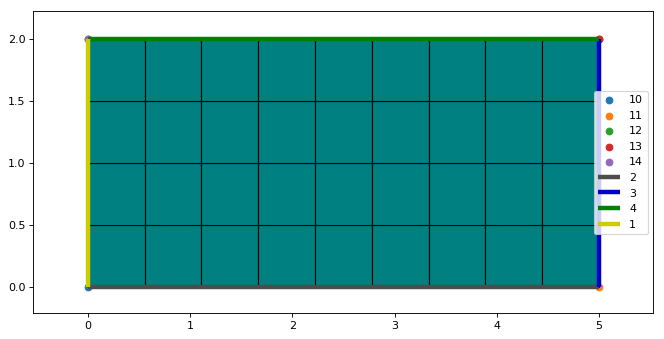

In [1]:
import sys 
sys.path.append(r'H:\TUM-PC\Dokumente\Projects\AMfe')

import amfe
import matplotlib.pyplot as plt
%matplotlib inline 
import numpy as np
import scipy
import copy
import pandas as pd

msh_dict = {}
msh_dict[0] = amfe.amfe_dir('meshes/test_meshes/1_rectangle_8_elem.msh')
msh_dict[1] = amfe.amfe_dir('meshes/test_meshes/retangule_5_by_2_quad_par_1.msh')
msh_dict[2] = amfe.amfe_dir('meshes/test_meshes/retangule_5_by_2_ref_quad_par_1.msh')
msh_dict[3] = amfe.amfe_dir('meshes/test_meshes/retangule_5_by_2_ref_tri_par_1.msh')
msh_dict[4] = amfe.amfe_dir('meshes/test_meshes/retangule_5_by_2_tri_par_1.msh')
msh_dict[5] = amfe.amfe_dir('meshes/test_meshes/retangule_square_hole_5_by_2_ref_tri_par_1.msh')
msh_dict[6] = amfe.amfe_dir('meshes/test_meshes/retangule_square_hole_5_by_2_quad_par_1.msh')

domain_id = {}
domain_id[0] = 6
domain_id[1] = 6
domain_id[2] = 6
domain_id[3] = 6
domain_id[4] = 6
domain_id[5] = 6
domain_id[6] = 6

bc = {}
bc[0] = [3,1,2]
bc[1] = [3,1,10]
bc[2] = [3,1,10]
bc[3] = [3,1,10]
bc[4] = [3,1,10]
bc[5] = [3,1,10]
bc[6] = [3,1,10]

# select mesh to be plotted
id = 1
mshfile = msh_dict[id]

# instanciating mesh class
m1 = amfe.Mesh()
m1.import_msh(mshfile)


fig, ax1=plt.subplots(1,figsize=(10, 5), dpi= 80, facecolor='w', edgecolor='k')
amfe.plot_mesh(m1,ax1)
plt.show()

In [2]:
my_material = amfe.KirchhoffMaterial(E=210E9, nu=0.3, rho=7.86E3, plane_stress=True, thickness=0.1)

value = 1e8
my_comp = amfe.MechanicalSystem()
my_comp.set_mesh_obj(m1)
my_comp.set_domain(domain_id[id],my_material)

my_comp2 = copy.deepcopy(my_comp)


# solving problem with dirichlet
my_comp.apply_neumann_boundaries(bc[id][0], value, 'normal')
my_comp.apply_dirichlet_boundaries(bc[id][1],'x')
my_comp.apply_dirichlet_boundaries(bc[id][2],'y')
s = amfe.LinearStaticsSolver(my_comp)
s.solve()

ue = my_comp.u_output[1]
# solving problem with pure Neumman
my_comp2.apply_neumann_boundaries(bc[id][0], value, 'normal')
my_comp2.apply_neumann_boundaries(bc[id][1], value, 'normal')

K, f_ext = my_comp2.assembly_class.assemble_k_and_f_neumann()
K, f_int = my_comp2.assembly_class.assemble_k_and_f()

K_inv = amfe.amna.pinv_and_null_space.compute(K,solver_opt='splusps')
R = K_inv.null_space

u_p = K_inv.apply(f_ext)

my_comp2.u_output.append(0*u_p)
my_comp2.u_output.append(u_p)

# checking with is possible to apply Rigid Body Correction to get to the same solution
error = ue - u_p
alpha = np.linalg.solve(R.T.dot(R),R.T.dot(error))

u_corr = K_inv.calc_kernel_correction(alpha)
new_error = ue - (u_p + u_corr)
norm_error = np.linalg.norm(new_error)
norm_ue = np.linalg.norm(ue)

ratio = norm_error/norm_ue
u_sol = u_p + u_corr
my_comp2.u_output[1] = u_sol





*************************************************************

 phys_group 6 with 8 elements successfully added.
Total number of elements in mesh: 8
*************************************************************
Preallocating the stiffness matrix
Done preallocating stiffness matrix with 8 elements and 30 dofs.
Time taken for preallocation: 0.00 seconds.

 phys_group 3 with 2 elements successfully added to Neumann Boundary.
Total number of neumann elements in mesh: 2
Total number of elements in mesh: 8
*************************************************************

 phys_group 1 with 3 nodes successfully added to Dirichlet Boundaries.
Total number of nodes with Dirichlet BCs: 3
Total number of constrained dofs: 3
*************************************************************

 phys_group 2 with 5 nodes successfully added to Dirichlet Boundaries.
Total number of nodes with Dirichlet BCs: 7
Total number of constrained dofs: 8
*************************************************************
Atte

C:\Users\ge72tih\AppData\Local\Continuum\anaconda3\envs\py36\lib\site-packages\scipy\sparse\sputils.py:115: UserWarning: object dtype is not supported by sparse matrices
  warnings.warn("object dtype is not supported by sparse matrices")
C:\Users\ge72tih\AppData\Local\Continuum\anaconda3\envs\py36\lib\site-packages\scipy\sparse\compressed.py:746: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  SparseEfficiencyWarning)


In [3]:
def plot_static(scale=1):
    fig, ax1=plt.subplots(1,figsize=(20, 5), dpi= 50, facecolor='w', edgecolor='k')
    amfe.plot_system_solution(my_comp, factor=scale, ax = ax1)
    
    fig, ax2=plt.subplots(1,figsize=(20, 5), dpi= 50, facecolor='w', edgecolor='k')
    amfe.plot_system_solution(my_comp2, factor=scale, ax = ax2)
    plt.show()

#plot_static(10)



from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

u = interact(plot_static,scale=(0,200,5)) 

interactive(children=(IntSlider(value=1, description='scale', max=200, step=5), Output()), _dom_classes=('widg…

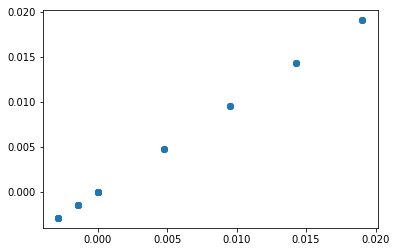

In [4]:
plt.plot(ue,u_sol,'o')

In [5]:
u_p

array([-0.02149328, -0.00498918, -0.00244566,  0.00317935, -0.00652993,
        0.0003222 , -0.02557755, -0.00784633, -0.01673138, -0.00294705,
       -0.01196947, -0.00090492, -0.00720757,  0.00113721, -0.00448779,
        0.00175077, -0.01129183, -0.00171993, -0.01605374, -0.00376206,
       -0.02081564, -0.00580419, -0.02353541, -0.00641776, -0.01877351,
       -0.00437562, -0.0140116 , -0.00233349, -0.0092497 , -0.00029136])

In [6]:
u_p


array([-0.02149328, -0.00498918, -0.00244566,  0.00317935, -0.00652993,
        0.0003222 , -0.02557755, -0.00784633, -0.01673138, -0.00294705,
       -0.01196947, -0.00090492, -0.00720757,  0.00113721, -0.00448779,
        0.00175077, -0.01129183, -0.00171993, -0.01605374, -0.00376206,
       -0.02081564, -0.00580419, -0.02353541, -0.00641776, -0.01877351,
       -0.00437562, -0.0140116 , -0.00233349, -0.0092497 , -0.00029136])

In [7]:
f_ext

array([-5.e+07,  0.e+00,  5.e+07,  0.e+00,  5.e+07,  0.e+00, -5.e+07,
        0.e+00,  0.e+00,  0.e+00,  0.e+00,  0.e+00,  0.e+00,  0.e+00,
        1.e+08,  0.e+00,  0.e+00,  0.e+00,  0.e+00,  0.e+00,  0.e+00,
        0.e+00, -1.e+08,  0.e+00,  0.e+00,  0.e+00,  0.e+00,  0.e+00,
        0.e+00,  0.e+00])

In [8]:
ue


array([ 0.        ,  0.        ,  0.01904762,  0.        ,  0.01904762,
       -0.00285714,  0.        , -0.00285714,  0.0047619 ,  0.        ,
        0.00952381,  0.        ,  0.01428571,  0.        ,  0.01904762,
       -0.00142857,  0.01428571, -0.00285714,  0.00952381, -0.00285714,
        0.0047619 , -0.00285714,  0.        , -0.00142857,  0.0047619 ,
       -0.00142857,  0.00952381, -0.00142857,  0.01428571, -0.00142857])

In [9]:
f_int


array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [10]:
K.todense()

matrix([[ 1.03846154e+10,  3.75000000e+09,  0.00000000e+00,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
          0.00000000e+00,  0.00000000e+00, -6.34615385e+09,
         -2.88461538e+08,  0.00000000e+00,  0.00000000e+00,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
          0.00000000e+00,  1.15384615e+09,  2.88461538e+08,
         -5.19230769e+09, -3.75000000e+09,  0.00000000e+00,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
        [ 3.75000000e+09,  1.03846154e+10,  0.00000000e+00,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
          0.00000000e+00,  0.00000000e+00,  2.88461538e+08,
          1.15384615e+09,  0.00000000e+00,  0.00000000e+00,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
          0.00000000e+00,  0.00000000e+

AttributeError: type object 'pinv_and_null_space' has no attribute 'U'